In [55]:
%matplotlib inline
import h5py
import pandas as pd
from sklearn import manifold

from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
sns.set()

random_seed = 42

In [191]:
%load_ext watermark
%watermark -v -m -p numpy,pandas,xgboost,tpot -g

CPython 3.6.4
IPython 6.2.1

numpy 1.14.2
pandas 0.22.0
xgboost 0.7.post3
tpot 0.9.2

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.9.0-6-amd64
machine    : x86_64
processor  : 
CPU cores  : 32
interpreter: 64bit
Git hash   :


In [8]:
%%sh

['fid_data', 'good_data', 'mixed_data']

In [85]:
bad = (pd.read_hdf('ISMS_PALM_data_dump.h5', 'fid_data')
       .assign(good=0)
       .sample(n=300000, random_state=random_seed))
       
good = (pd.read_hdf('ISMS_PALM_data_dump.h5', 'good_data')
        .assign(good=1)
        .sample(n=300000, random_state=random_seed))

df = pd.concat([bad, good]).sample(frac=1.0)  # put them together and then shuffle

feature_cols = ['nphotons', 'sigma_x', 'sigma_y', 'sigma_z', 'offset', 'amp', 'chi2']
X = df.loc[:, feature_cols]
y = df.good

In [86]:
X.head(10)

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
5454980,1647.0,0.054149,0.055213,44.686230,71.646240,177.189423,516.517273
5528341,12450.0,0.012665,0.012396,9.354234,57.842274,1335.017334,880.020813
10024252,565.0,0.093971,0.098288,72.574249,31.856213,61.119827,292.584290
5980119,2287.0,0.059448,0.042550,59.383900,62.590393,189.133575,726.310364
3229255,656.0,0.082335,0.091846,66.839844,35.247017,71.023918,222.232803
7896992,8814.0,0.013645,0.027530,19.784918,49.643887,674.865234,596.348511
6375976,13530.0,0.012877,0.011684,9.478099,55.144283,1421.523560,801.165527
8227170,617.0,0.080501,0.115715,76.930168,31.688951,61.321278,185.843506
8473534,791.0,0.079055,0.072759,62.919807,33.590023,83.812576,180.519516
7752060,675.0,0.077323,0.093204,66.080345,32.473724,72.563255,156.831009


Summary stats

In [46]:
X.describe()

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
count,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000
mean,5230.885438,0.054990,0.065291,51.791564,46.584478,502.148625,566.552945
std,7676.040465,0.036977,0.043759,35.367183,19.822368,743.828376,596.173199
min,500.000000,0.003493,0.003852,2.955715,0.006650,50.000080,83.454880
25%,664.000000,0.014367,0.019590,13.248857,31.906822,65.480406,203.879444
50%,1125.000000,0.060857,0.066356,55.316990,43.821569,110.677330,356.539169
75%,8833.000000,0.083618,0.099500,78.232935,53.791242,852.451401,743.720383
max,114269.000000,0.249763,0.248705,246.504898,511.695892,12033.718750,10297.985352


Correlation

In [176]:
X.corr()

,nphotons,sigma_x,sigma_y,sigma_z,offset,amp,chi2
nphotons,1.000000,-0.675072,-0.654934,-0.659092,0.677235,0.987815,0.899265
sigma_x,-0.675072,1.000000,0.841006,0.949682,-0.386932,-0.667188,-0.571736
sigma_y,-0.654934,0.841006,1.000000,0.904465,-0.401427,-0.655001,-0.579353
sigma_z,-0.659092,0.949682,0.904465,1.000000,-0.348163,-0.660407,-0.548419
offset,0.677235,-0.386932,-0.401427,-0.348163,1.000000,0.665127,0.765688
amp,0.987815,-0.667188,-0.655001,-0.660407,0.665127,1.000000,0.870322
chi2,0.899265,-0.571736,-0.579353,-0.548419,0.765688,0.870322,1.000000


Counts of good vs. bad

In [45]:
y.value_counts()

1    300000
0    300000
Name: good, dtype: int64

Check no missing values

In [49]:
assert X.isnull().values.ravel().sum() == 0

### Visualize

In [80]:
%%time

n_components = 2
tsne_sample_size = 5000
xx = X.head(tsne_sample_size)
yy = y[:tsne_sample_size]
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
zz = tsne.fit_transform(xx)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 986 µs


In [83]:
fig, ax = plt.subplots()
ax.scatter(zz[yy == 1, 0], zz[yy == 1, 1], s=2, c='b', alpha=0.5, label='good')
ax.scatter(zz[yy == 0, 0], zz[yy == 0, 1], s=2, c='r', alpha=0.5, label='bad')
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter()) 
plt.legend()
plt.show()

### Models

Train/test split

In [157]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [158]:
X_train.shape, y_train.shape

((480000, 7), (480000,))

In [159]:
X_test.shape, y_test.shape

((120000, 7), (120000,))

In [185]:
from sklearn.metrics import *
from sklearn.metrics.classification import *

def evaluate_preds(y_hat):
    return pd.Series({
        'precision': precision_score(y_test, y_hat),
        'recall': recall_score(y_test, y_hat),
        'f1': f1_score(y_test, y_hat),
        'accuracy': accuracy_score(y_test, y_hat),
        'roc_auc': roc_auc_score(y_test, y_hat)
    })

def evaluate(clf):
    y_hat = clf.predict(X_test)
    return evaluate_preds(y_hat)

def feature_importances(clf):
    pd.Series(dict(zip(X.columns, clf.feature_importances_))).sort_index().plot.bar()
    plt.show()

#### K Nearest Neighbors

In [161]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [162]:
evaluate(knn)

accuracy     0.983508
f1           0.983620
precision    0.979267
recall       0.988011
roc_auc      0.983498
dtype: float64

#### Random forest

In [163]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [164]:
evaluate(rf)

accuracy     0.986450
f1           0.986525
precision    0.983395
recall       0.989674
roc_auc      0.986442
dtype: float64

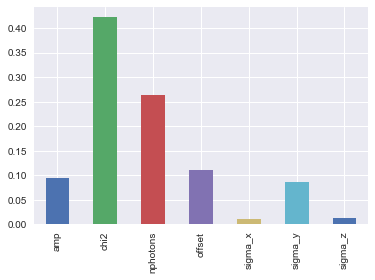

In [165]:
feature_importances(rf)

### Naive Bayes

In [166]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)

GaussianNB(priors=None)

In [167]:
evaluate(nb)

accuracy     0.959408
f1           0.960098
precision    0.946186
recall       0.974426
roc_auc      0.959373
dtype: float64

### XGBoost

In [168]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth=5, n_estimators=100, nthread=16)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=16, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [169]:
evaluate(xgb)

/home/isaac/miniconda3/envs/data/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy     0.986458
f1           0.986566
precision    0.981043
recall       0.992152
roc_auc      0.986445
dtype: float64

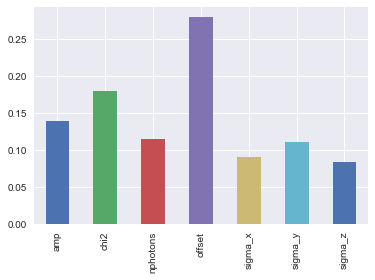

In [170]:
feature_importances(xgb)

#### Logistic regression

(This does amazingly well for a fast-to-train linear model.)

In [171]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(n_jobs=16)
lr.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=16, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [172]:
evaluate(lr)

accuracy     0.972675
f1           0.972997
precision    0.963846
recall       0.982325
roc_auc      0.972652
dtype: float64

#### Big guns: TPOT

In [132]:
from tpot import TPOTClassifier

tp = TPOTClassifier(generations=5, max_time_mins=15, population_size=50, n_jobs=24, verbosity=2)
tp.fit(X_train, y_train)

Optimization Progress: 139pipeline [19:14, 248.78s/pipeline]

Generation 1 - Current best internal CV score: 0.9874708347645444



19.357010333333335 minutes have elapsed. TPOT will close down.
TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: XGBClassifier(RobustScaler(input_matrix), learning_rate=0.5, max_depth=4, min_child_weight=6, n_estimators=100, nthread=1, subsample=0.7000000000000001)


TPOTClassifier(config_dict={'sklearn.naive_bayes.GaussianNB': {}, 'sklearn.naive_bayes.BernoulliNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.naive_bayes.MultinomialNB': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0], 'fit_prior': [True, False]}, 'sklearn.tree.DecisionT....3 , 0.35, 0.4 , 0.45, 0.5 , 0.55,
       0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])}}}},
        crossover_rate=0.1, cv=5, disable_update_check=False,
        early_stop=None, generations=1000000, max_eval_time_mins=5,
        max_time_mins=15, memory=None, mutation_rate=0.9, n_jobs=24,
        offspring_size=50, periodic_checkpoint_folder=None,
        population_size=50, random_state=None, scoring=None, subsample=1.0,
        verbosity=2, warm_start=False)

Turns out TPOT ended up with just a XGBoost classifier with a Robust Scaler for the inputs before they go in.

In [133]:
tp.export('tpot_pipeline.py')

True

In [134]:
evaluate(tp)

/home/isaac/miniconda3/envs/data/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy     0.988100
f1           0.988103
precision    0.983302
recall       0.992951
roc_auc      0.988122
dtype: float64

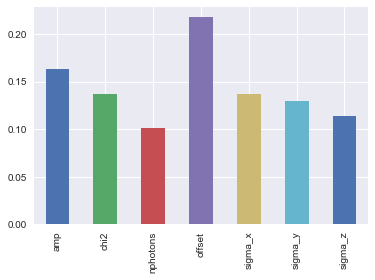

In [136]:
feature_importances(tp.fitted_pipeline_.steps[-1][1])

<hr>

## Voting classifier (ensemble of above)

In [183]:
from sklearn.ensemble import VotingClassifier

estimators = [
    ('rf', rf),
    ('lr', lr),
    ('knn', knn),
    ('nb', nb),
    ('xgb', tp),
]

predictions = (pd.DataFrame({name: model.predict(X_test) for name, model in estimators})
               .assign(vote_ratio=lambda x: x.sum(axis=1) / len(estimators))
               .assign(y_hat=lambda x: (x.vote_ratio > 0.5).astype(np.int)))

/home/isaac/miniconda3/envs/data/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [184]:
predictions.head(10)

,knn,lr,nb,rf,xgb,vote_ratio,y_hat
0,0,0,0,0,0,0.0,0
1,1,1,1,1,1,1.0,1
2,0,0,0,0,0,0.0,0
3,1,1,1,1,1,1.0,1
4,0,0,0,0,0,0.0,0
5,0,0,0,0,0,0.0,0
6,0,0,0,0,0,0.0,0
7,1,1,1,1,1,1.0,1
8,1,1,1,1,1,1.0,1
9,0,0,0,0,0,0.0,0


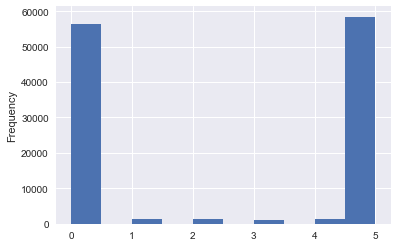

In [179]:
predictions.votes.plot.hist()

In [186]:
evaluate_preds(predictions.y_hat)

accuracy     0.985725
f1           0.985849
precision    0.979578
recall       0.992202
roc_auc      0.985710
dtype: float64